In [1]:
import sys

sys.path.insert(0, '/Volumes/data/LosAlamosSummer')
sys.path.insert(0, '/Volumes/data/LosAlamosSummer/DrOsborneCode')

import Utilities as ut
import importlib
import model as mod
import predict_with_uncertainty as pu
import custom as cus
importlib.reload(ut)
importlib.reload(mod)
importlib.reload(pu)
importlib.reload(cus)
import scipy
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers

In [2]:
import pandas as pd

df = pd.read_excel ('/Volumes/data/LosAlamosSummer/Serializationstructures.xlsx')
print (df)
print(df.LWR)
SS=np.array(df.LWR[:-1])
print(SS)

            Sphere           LWR           SFR
0     2.615712e+02  1.000000e-03  1.000000e-03
1     5.737464e+02  6.865624e-03  6.865624e-03
2     8.888122e+02  9.160728e-03  9.160728e-03
3     1.195336e+03  1.107134e-02  1.107134e-02
4     1.481597e+03  1.273122e-02  1.273122e-02
...            ...           ...           ...
997   4.267269e+06  7.188363e+06  7.188363e+06
998   4.568146e+06  7.556836e+06  7.556836e+06
999   4.976225e+06  8.021766e+06  8.021766e+06
1000  5.607251e+06  8.701618e+06  8.701618e+06
1001  7.020693e+06           NaN           NaN

[1002 rows x 3 columns]
0       1.000000e-03
1       6.865624e-03
2       9.160728e-03
3       1.107134e-02
4       1.273122e-02
            ...     
997     7.188363e+06
998     7.556836e+06
999     8.021766e+06
1000    8.701618e+06
1001             NaN
Name: LWR, Length: 1002, dtype: float64
[1.00000000e-03 6.86562376e-03 9.16072825e-03 ... 7.55683605e+06
 8.02176620e+06 8.70161772e+06]


In [3]:
#datapath = '/Users/jessiejo/data/VBUDS/GroupStructurePaper/NeuralNetworks/All_Libraries/NewDataSetFull1.mat'
datapath='/Volumes/data/LosAlamosSummer/LWR/DATA/LWR_data_7.mat'
print('Loading In Data')
kinfBOL,kinfMOL,kinfEOL,GS=ut.LoadData(datapath,1)
#MakeGroupDensity(X, nDecades)
Nfeatures = 1000;
allData= ut.ProcessData(datapath, 1,1000,1,SS,1)
# allData: (100,000x1,000) y_direct: (100,000x3)
print('Finished Loading Data')

Loading In Data
Finished Loading Data


In [4]:
#!pip install -q -U keras-tuner
print(kinfBOL.shape)
print(len(kinfBOL))
kinf=np.array(np.zeros((len(kinfBOL),3)))
kinf[:,0]=kinfBOL
kinf[:,1]=kinfMOL
kinf[:,2]=kinfEOL#np.concatenate((kinfBOL,kinfMOL,kinfEOL),axis=0)
print(kinf.shape)

(49999,)
49999
(49999, 3)


In [5]:
Nsamples,Ndecades = allData.shape
vldF=.1
testF=.2
normConst=1#np.linalg.norm(kinf)
y_norm=np.array(kinf/normConst)

X, X_test, y, y_test, vldF_corr = ut.makeFractions(Nsamples, vldF, testF, allData, y_norm, 1)


NtrainingSamples = int(Nsamples*(1 - testF))
tranValSplit=int(NtrainingSamples*(1-vldF_corr))
X_train=X[:tranValSplit,:]
y_train=y[:,:tranValSplit]
X_val=X[tranValSplit+1:,:]
y_val=y[:,tranValSplit+1:]
print(y_test.shape)
print(y_val.shape)
print(y_norm.shape)
print(y_train.shape)

(3, 9999)
(3, 4999)
(49999, 3)
(3, 34999)


In [6]:
batch_size=134
model = tf.keras.Sequential([
    layers.Dense(205, activation='elu', name='hidden_1', input_dim=1000),
    layers.Dense(328, activation='elu',  name='hidden_2'),
    layers.Dense(3, activation='linear',name='output')])
model.compile(loss="mean_squared_logarithmic_error",metrics="mean_squared_logarithmic_error")
model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 205)               205205    
_________________________________________________________________
hidden_2 (Dense)             (None, 328)               67568     
_________________________________________________________________
output (Dense)               (None, 3)                 987       
Total params: 273,760
Trainable params: 273,760
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(loss='MAE',optimizer=tf.keras.optimizers.Adam(1e-3))
model.fit(X_train,y_train.T, epochs=800, batch_size=batch_size, verbose=1,validation_data=(X_val,y_val.T), callbacks=cus.callbacks())
model.compile(loss='MAE',optimizer=tf.keras.optimizers.Adam(1e-4))
model.fit(X_train,y_train.T, epochs=800, batch_size=batch_size, verbose=1,validation_data=(X_val,y_val.T), callbacks=cus.callbacks())
model.compile(loss='MAE',optimizer=tf.keras.optimizers.Adam(1e-5))
model.fit(X_train,y_train.T, epochs=800, batch_size=batch_size, verbose=1,validation_data=(X_val,y_val.T), callbacks=cus.callbacks())
model.compile(loss='MAE',optimizer=tf.keras.optimizers.Adam(1e-6))
model.fit(X_train,y_train.T, epochs=800, batch_size=batch_size, verbose=1,validation_data=(X_val,y_val.T), callbacks=cus.callbacks())

Epoch 1/800
262/262 [==============================] - 1s 3ms/step - loss: 0.1640 - val_loss: 0.1263
Epoch 2/800
262/262 [==============================] - 1s 3ms/step - loss: 0.0788 - val_loss: 0.0654
Epoch 3/800
262/262 [==============================] - 1s 3ms/step - loss: 0.0510 - val_loss: 0.0498
Epoch 4/800
262/262 [==============================] - 1s 3ms/step - loss: 0.0399 - val_loss: 0.0369
Epoch 5/800
262/262 [==============================] - 1s 3ms/step - loss: 0.0365 - val_loss: 0.0319
Epoch 6/800
262/262 [==============================] - 1s 3ms/step - loss: 0.0323 - val_loss: 0.0343
Epoch 7/800
262/262 [==============================] - 1s 3ms/step - loss: 0.0317 - val_loss: 0.0295
Epoch 8/800
262/262 [==============================] - 1s 3ms/step - loss: 0.0294 - val_loss: 0.0353
Epoch 9/800
262/262 [==============================] - 1s 3ms/step - loss: 0.0284 - val_loss: 0.0282
Epoch 10/800
262/262 [==============================] - 1s 4ms/step - loss: 0.0272 - val_lo

262/262 [==============================] - 1s 4ms/step - loss: 0.0082 - val_loss: 0.0168
Epoch 82/800
262/262 [==============================] - 1s 4ms/step - loss: 0.0080 - val_loss: 0.0159
Epoch 83/800
262/262 [==============================] - 1s 4ms/step - loss: 0.0077 - val_loss: 0.0159
Epoch 84/800
262/262 [==============================] - 1s 4ms/step - loss: 0.0079 - val_loss: 0.0156
Epoch 85/800
262/262 [==============================] - 1s 4ms/step - loss: 0.0076 - val_loss: 0.0159
Epoch 86/800
262/262 [==============================] - 1s 4ms/step - loss: 0.0074 - val_loss: 0.0167
Epoch 87/800
262/262 [==============================] - 1s 4ms/step - loss: 0.0079 - val_loss: 0.0152
Epoch 88/800
262/262 [==============================] - 1s 4ms/step - loss: 0.0077 - val_loss: 0.0154
Epoch 89/800
262/262 [==============================] - 1s 4ms/step - loss: 0.0078 - val_loss: 0.0169
Epoch 90/800
262/262 [==============================] - 1s 4ms/step - loss: 0.0073 - val_loss: 

262/262 [==============================] - 1s 4ms/step - loss: 0.0019 - val_loss: 0.0126
Epoch 10/800
262/262 [==============================] - 1s 4ms/step - loss: 0.0019 - val_loss: 0.0126
Epoch 11/800
262/262 [==============================] - 1s 4ms/step - loss: 0.0018 - val_loss: 0.0126
Epoch 12/800
262/262 [==============================] - 1s 4ms/step - loss: 0.0018 - val_loss: 0.0126
Epoch 13/800
262/262 [==============================] - 1s 4ms/step - loss: 0.0018 - val_loss: 0.0126
Epoch 14/800
262/262 [==============================] - 1s 4ms/step - loss: 0.0018 - val_loss: 0.0127
Epoch 15/800
262/262 [==============================] - 1s 4ms/step - loss: 0.0018 - val_loss: 0.0126
Epoch 16/800
262/262 [==============================] - 1s 4ms/step - loss: 0.0017 - val_loss: 0.0126
Epoch 17/800
262/262 [==============================] - 1s 4ms/step - loss: 0.0017 - val_loss: 0.0126
Epoch 18/800
262/262 [==============================] - 1s 4ms/step - loss: 0.0017 - val_loss: 

In [8]:
y_predicted = model.predict(X_test)
metric = tf.keras.metrics.MeanSquaredError(name="mean_average_error", dtype=None)
metric.update_state(np.array(y_predicted*normConst),np.array(y_test.T*normConst))
metric.result().numpy()

0.0011236523

In [9]:
from matplotlib import pyplot as plt
import numpy as np


(9999, 3)


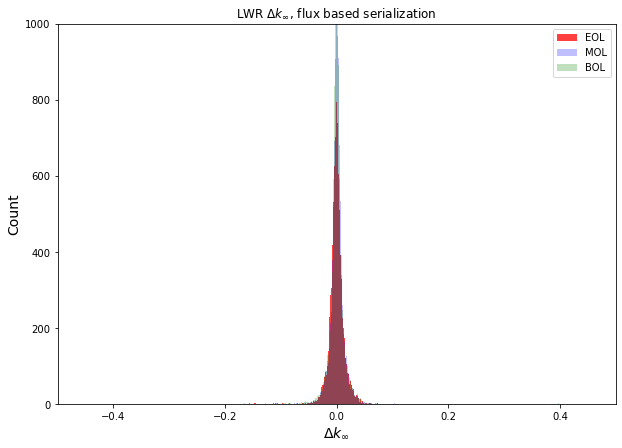

In [10]:
# Creating dataset
a = (y_predicted-y_test.T)
print(a.shape)
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a[:,2],bins=500,alpha=0.75,label="EOL",color='r')
ax.hist(a[:,1],bins=500,alpha=0.25,label="MOL",color='b')
ax.hist(a[:,0],bins=500,alpha=0.25,label="BOL",color='g')
plt.xlabel("$Δk_{\infty}$", size=14)
plt.ylabel("Count", size=14)
plt.title("LWR $Δk_{\infty}$, flux based serialization")
plt.legend(loc='upper right')
plt.xlim([-0.5,0.5])
plt.ylim([0,1000])

plt.savefig("PICS/LWR_deltaK_shaped.png",bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w',
            orientation ='landscape')

# Show plot
plt.show()


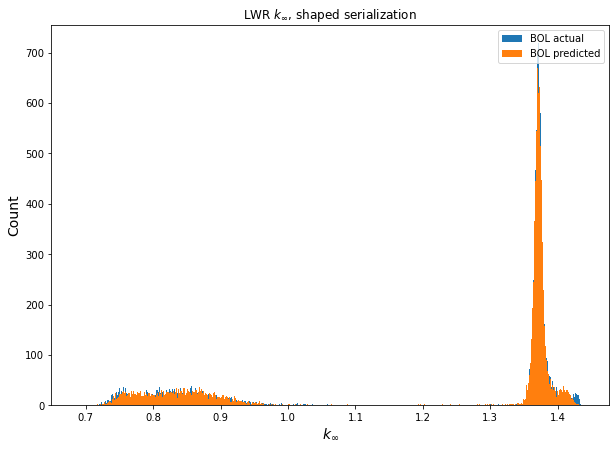

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
 

n_bins = 500
 

# Creating histogram
fig, axs = plt.subplots(figsize =(10, 7))
 
axs.hist(y_test.T[:,0], bins = n_bins,label="BOL actual")
axs.hist(y_predicted[:,0], bins = n_bins,label="BOL predicted")


plt.xlabel("$k_{\infty}$", size=14)
plt.ylabel("Count", size=14)
plt.legend(loc='upper right')

plt.title("LWR $k_{\infty}$, shaped serialization")
plt.savefig("PICS/kinfPredDist_shaped.png",bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w',
            orientation ='landscape')

plt.show()
# Show plot



In [13]:

print(np.std(a[:,0]))
print(np.std(a[:,1]))
print(np.std(a[:,2]))



0.035965005992451955
0.03406690454516413
0.03026876187655921
